# Continuous Control

Run this notebook end-to-end to complete Project 2 - Continuous Control of Udacity's Deep Reinforcement Learning Nanodegree program.

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


Import all python packages needed to execute the notebook.

In [2]:
#!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

In [3]:
from collections import namedtuple, deque
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
from workspace_utils import active_session

The environment is already saved in the Workspace and can be accessed at the file path provided below. However, if running this notebook locally, or using the single-arm environment, change `PATH_TO_ENV` to the appropriate file path.

(Note: The Unity ML environments are saved in the git repo for this project)

In [4]:
#PATH_TO_ENV = "/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64"  # single agent path
PATH_TO_ENV = "/data/Reacher_Linux_NoVis/Reacher.x86_64"  # multi-agent path
env = UnityEnvironment(file_name=PATH_TO_ENV)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


**Aside**: Unity environments contain <b>*brains*</b> which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(f"brain name: {brain_name}\nbrain type: {type(brain)}")

brain name: ReacherBrain
brain type: <class 'unityagents.brain.BrainParameters'>


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.18299999590963126


### 4. Train the agent

**NOTE**: A majority of DDPG boilerplate code was recycled from the DDPG exercise.

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:

- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:

```python
env_info = env.reset(train_mode=True)[brain_name]
```

- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

First, lets determine which device we are using. This will changed whether running this notebook on CPU or GPU hardware.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

The algorithm being used is the **Deep Deterministic Policy Gradient (DDPG)**. The algorithm learns both a policy and a value function at the same time through the use of an Actor (the policy) and a Critic (the value function estimator). DDPG is often considered Deep Q-Learning but when the action space is continuous, as it is for the environment we are trying to solve.

Next, we need to set the value for all of the hyperparameters used during learning. 

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # soft update ratio
LR_ACTOR = 1e-3         # actor learning rate
LR_CRITIC = 1e-3        # critic learning rate
WEIGHT_DECAY = 0        # L2 weight decay
MAX_T = 1000            # max number of timesteps per episode
LEARN_EVERY = 20        # how many timesteps to learn after
LEARN_NUM   = 10        # how many learning updates to run
GRAD_CLIPPING = 1.0     # max/min to clip gradients at
EPSILON = 1.0           # O/U noise factor
EPSILON_DECAY = 1e-6    # O/U noise factor decay
OU_SIGMA  = 0.2         # O/U sigma
OU_THETA  = 0.15        # O/U theta
SOLVED_REWARD = 30.0    # reward where environment is considered solved
SOLVED_TIMESTEPS = 100  # min timesteps needed to solve environment

The models we are using for the Actor and Critic are fully connected dense networks, with a batch normalization layer just after the input layer to normalize across the minibatches that are fed forward through the networks. The activation layer at the output of the Actor is a Tanh function to surpress the possible continuous actions to (-1, 1). There is no activation layer at the output of the Critic as we want to Critic to be learning the value of each state-action pair.

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The Agent contains both a local and target version of the Actor and Critic, which helps to stablize learning. We add Ornstein-Uhlenbeck noise to the action process to simulate the same type of exploration-exploitation behavior in traditional DQN, with this noise factor decaying over time.

The Agent contains a Replay Buffer where we store experiences to sample from during learning. As the Agent interacts with the environment, experiences are added to the buffer for later use. The older experiences will fall out of the buffer as new ones are added.

In order to promote smooth learning, we include a soft update of the target network parameters from the local networks parameters for both the Actor and the Critic. This insures we don't take too large of steps in the learning process. We can also control learning by performing `n` forward and back prop passes every `m` timesteps.

In [11]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=OU_THETA, sigma=OU_SIGMA):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.epsilon = EPSILON

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        # Save experience / reward
        # If updating in batches, then add the last memory of the agents (e.g. 20 agents) to a buffer
        # and if we've met batch size only push to learn in multiples of whatever LEARN_NUM specifies (e.g.10)
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
            for _ in range(LEARN_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.epsilon * self.noise.sample()

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # gradient clipping for critic
        if GRAD_CLIPPING > 0:
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), GRAD_CLIPPING)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)    

        # --------------------- and update epsilon decay ----------------------- # 
        if EPSILON_DECAY > 0:                
            self.epsilon -= EPSILON_DECAY
            self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Lets initialize the Agent and print the network architecture for the Actor and Critic.

In [14]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

print("Actor architecture")
print(agent.actor_local)

print("Critic architecture")
print(agent.critic_local)

Actor architecture
Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic architecture
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


The DDPG training algorithm is defined in the function below. This is where the Agent interacts with the environment, saves experiences, and performs learning.

The function prints out status messages showing the progress of learning, and completes once the environment has been considered solved (average score of 30 over the previos 100 episodes)

In [15]:
def ddpg(n_episodes=1000,
         max_t=1000,
         print_every=1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results
        
    Returns
    =======
        scores (list)       : list of mean scores for each episode
    """
    
    mean_scores = []                               # list of mean scores from each episode
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment    
        states = env_info.vector_observations              # get the current state (for each agent)
        scores = np.zeros(num_agents)                      # initialize score for each agent
        agent.reset()                                      # reset the agent
        t0 = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)    # select an action
            
            env_info = env.step(actions)[brain_name]       # send all actions to the environment
            next_states = env_info.vector_observations     # get next state
            rewards = env_info.rewards                     # get reward
            dones = env_info.local_done                    # check if episode finished
            
            # save experience to replay buffer
            # perform learning step per hyperparameters
            for _s, _a, _r, _ns, _d in zip(states, actions, rewards, next_states, dones):
                agent.step(_s, _a, _r, _ns, _d, t)             
            
            states = next_states
            scores += rewards        
            
            if np.any(dones):                              # exit loop when episode ends
                break

        episode_mean_score = np.mean(scores)               # calculate episode mean score
        mean_scores.append(episode_mean_score)             # save mean score for the episode
        scores_window.append(episode_mean_score)           # save mean score to window
        running_mean = np.mean(scores_window)
        
        if i_episode % print_every == 0:
            _d = round(time.time() - t0)
            _m = round(episode_mean_score, 2)
            _ma = round(running_mean, 2)
            print(f'\rEpisode {i_episode} ({_d}s)\tMean: {_m}\tMoving Avg: {_ma}')
                  
        if running_mean >= SOLVED_REWARD and i_episode >= SOLVED_TIMESTEPS:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {running_mean}')            
            break
            
    return mean_scores

Keep the environment running with helper function from Udacity.

In [16]:
t0 = time.time()
 
with active_session():
    scores = ddpg(max_t=MAX_T)

t1 = time.time()
elapsed_time = (t1 - t0) / 60.0
print(f"\nElapsed Time: {round(elapsed_time, 2)} mins")

Episode 1 (114s)	Mean: 0.73	Moving Avg: 0.73
Episode 2 (117s)	Mean: 1.5	Moving Avg: 1.12
Episode 3 (117s)	Mean: 2.28	Moving Avg: 1.5
Episode 4 (119s)	Mean: 2.78	Moving Avg: 1.82
Episode 5 (120s)	Mean: 3.31	Moving Avg: 2.12
Episode 6 (122s)	Mean: 2.99	Moving Avg: 2.27
Episode 7 (121s)	Mean: 3.51	Moving Avg: 2.44
Episode 8 (122s)	Mean: 4.11	Moving Avg: 2.65
Episode 9 (122s)	Mean: 5.31	Moving Avg: 2.95
Episode 10 (126s)	Mean: 7.02	Moving Avg: 3.35
Episode 11 (123s)	Mean: 7.5	Moving Avg: 3.73
Episode 12 (124s)	Mean: 6.24	Moving Avg: 3.94
Episode 13 (126s)	Mean: 7.94	Moving Avg: 4.25
Episode 14 (129s)	Mean: 8.86	Moving Avg: 4.58
Episode 15 (131s)	Mean: 8.85	Moving Avg: 4.86
Episode 16 (134s)	Mean: 10.54	Moving Avg: 5.22
Episode 17 (136s)	Mean: 10.75	Moving Avg: 5.54
Episode 18 (138s)	Mean: 11.49	Moving Avg: 5.87
Episode 19 (138s)	Mean: 11.45	Moving Avg: 6.17
Episode 20 (141s)	Mean: 13.79	Moving Avg: 6.55
Episode 21 (143s)	Mean: 13.64	Moving Avg: 6.89
Episode 22 (146s)	Mean: 14.11	Moving Avg

NameError: name 'elabsed_time' is not defined

For the sake of not wasting any more run time to replicate the results for a typo, i'll leave the error message there for now.

In [17]:
print(f"\nElapsed Time: {round(elapsed_time, 2)} mins")


Elapsed Time: 352.7 mins


When finished training, you can close the environment.

In [18]:
env.close()

### 5. Visualizing results and saving best model

Below we can see the model scores for each episode combined with the 100 episode moving average. The moving average trend is useful to show the overall progress of learning when individual episodes may appear noisy.

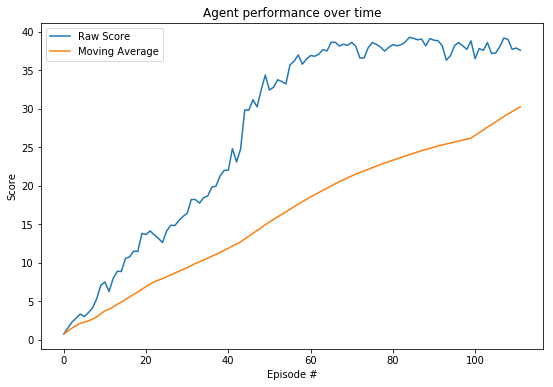

In [22]:
# plot the scores
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label="Raw Score")

# plot the moving average
scores_series = pd.Series(scores)
windows = scores_series.rolling(100, min_periods=1)
ma = windows.mean().dropna()
x, y = ma.index, ma.values
plt.plot(x, y, label="Moving Average")

plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Agent performance over time")
plt.legend()

fig.savefig("performance.png")

In [23]:
# save model
torch.save(agent.actor_local.state_dict(), "actor_checkpoint.pth")
torch.save(agent.critic_local.state_dict(), "critic_checkpoint.pth")

### 6. Potential Improvements

Some additional ideas that could lead to better performance or interesting insights include:

* Different model architectures (more/less layers, larger/smaller layer sizes)
* Prioritized replay buffer
* Training on the 1-arm environment versus the 20-arm environment may lead to different performance
* Different policy gradient algorithms like A3C or SAC